In [86]:
# Import necessary modules

%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt
# from scipy.fftpack import fft

LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2024-04-17 16:43:02,188 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c5:6d:2f:4b
2024-04-17 16:43:06,367 | INFO     |: Connected to c0:89:c5:6d:2f:4b


In [88]:
yaw = []
ref_angle = []
tof_reading = []    # Stores the sensor reading in centimeters
tof2_reading = []    # Stores the sensor reading in centimeters
pid_ctrl = []
p_ctrl = []
i_ctrl = []
d_ctrl = []
pid_error = []
timestamp = []      # Timestamps in milliseconds

def notification_handler(uuid, byte_array):
    yaw.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[0])))
    ref_angle.append(((int) (ble.bytearray_to_string(byte_array).split(", ")[1])))
    tof_reading.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[2]))*0.1)
    pid_ctrl.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[3])))
    p_ctrl.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[4])))
    i_ctrl.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[5])))
    d_ctrl.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[6])))
    pid_error.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[7])))
    tof2_reading.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[-2]))*0.1)
    timestamp.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[-1])))

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [178]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [179]:
ble.send_command(CMD.KP_SET, "5")
ble.send_command(CMD.KI_SET, "0.01")
ble.send_command(CMD.KD_SET, "500")

# ble.send_command(CMD.KP_SET, "0")
# ble.send_command(CMD.KI_SET, "0")
# ble.send_command(CMD.KD_SET, "0")

In [180]:
yaw.clear()
ref_angle.clear()
tof_reading.clear()
tof2_reading.clear()
pid_ctrl.clear()
p_ctrl.clear()
i_ctrl.clear()
d_ctrl.clear()
pid_error.clear()
timestamp.clear()

ble.send_command(CMD.START_MAPPING, "")

In [181]:
ble.send_command(CMD.STOP_MAPPING, "")

In [182]:
ble.send_command(CMD.GET_DATA_MAP, "")

In [183]:
timestamp[-1]-timestamp[0]

17999.0

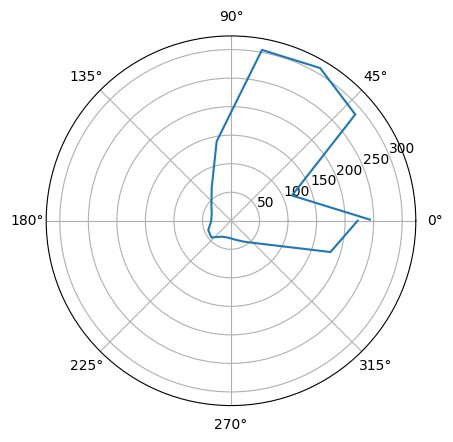

In [195]:
# import math
yaw
yaw_radian = []
for yaw_i in yaw:
    yaw_radian.append(math.radians(-yaw_i))
plt.polar(yaw_radian, tof_reading)
# plt.polar(yaw_radian, tof2_reading)

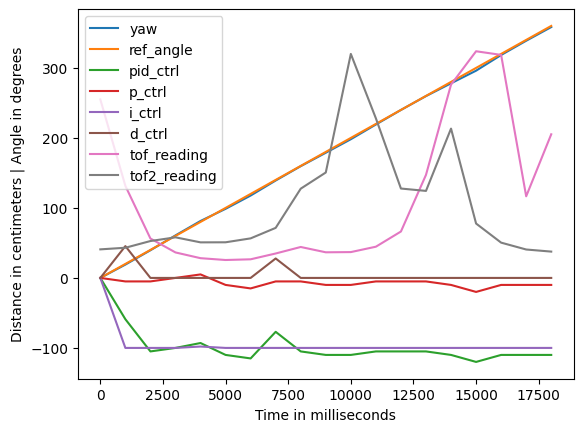

In [161]:
data_N = len(timestamp)

# Time domain figure
time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=data_N)
plt.plot(time, yaw, label='yaw')
plt.plot(time, ref_angle, label='ref_angle')
plt.plot(time, pid_ctrl, label='pid_ctrl')
plt.plot(time, p_ctrl, label='p_ctrl')
plt.plot(time, i_ctrl, label='i_ctrl')
plt.plot(time, d_ctrl, label='d_ctrl')
plt.plot(time, tof_reading, label='tof_reading')
plt.plot(time, tof2_reading, label='tof2_reading')
# plt.plot(time, i_ctrl, label='i_ctrl')
plt.legend()
plt.title('')
# plt.xlim(0, 2000)
# plt.ylim(-300, 2000)
plt.xlabel('Time in milliseconds')
plt.ylabel('Distance in centimeters | Angle in degrees')
plt.show()

In [ ]:
# Merge and Plot

yaw_radian_ = []
for yaw_i in yaw_:
    yaw_radian_.append(math.radians(yaw_i))

# Rotate
x1 = [r/30.48 * np.cos(theta) for r, theta in zip(tof_reading_, yaw_radian_)]
y1 = [r/30.48 * np.sin(theta) for r, theta in zip(tof_reading_, yaw_radian_)]

# Shift
x1 = [i + 5 for i in x1]
y1 = [j + 3 for j in y1]

indices = [i for i, val in enumerate(yaw_) if val % 20 == 0]
yaw_filtered = []
x1_filtered = []
y1_filtered = []
for i in range(0, int(max(yaw_))+1, 20):
    idx = min(range(len(yaw_)), key=lambda j: abs(yaw_[j] - i))
    yaw_filtered.append(yaw_[idx])
    x1_filtered.append(x1[idx])
    y1_filtered.append(y1[idx])

plt.figure()
plt.scatter(x1_filtered, y1_filtered, s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot at (5,3)')
plt.show()

In [186]:
# Export the data
import csv

data = list(zip(yaw,ref_angle,tof_reading,pid_ctrl,p_ctrl,i_ctrl,d_ctrl,pid_error,timestamp))
file_name = 'new_quarant4th.csv'

# Write the data to a CSV file
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Yaw', 'Ref Angle', 'TOF Reading', 'PID Ctrl', 'P Ctrl', 'I Ctrl', 'D Ctrl', 'PID Error', 'Time Stamp'])  # Write header
    writer.writerows(data)  # Write data

In [187]:
# Initialize empty lists to store the data
yaw_ = []
ref_angle_ = []
tof_reading_ = []
pid_ctrl_ = []
p_ctrl_ = []
i_ctrl_ = []
d_ctrl_ = []
pid_error_ = []
timestamp_ = []

# Read the data from the CSV file
with open(file_name, 'r', newline='') as file:
    reader = csv.reader(file)
    header = next(reader)  # Read the header row
    for row in reader:
        yaw_.append(float(row[0]))
        ref_angle_.append(float(row[1]))
        tof_reading_.append(float(row[2]))
        pid_ctrl_.append(float(row[3]))
        p_ctrl_.append(float(row[4]))
        i_ctrl_.append(float(row[5]))
        d_ctrl_.append(float(row[6]))
        pid_error_.append(float(row[7]))
        timestamp_.append(int(float(row[8])))

# # Print the data
# for i in range(len(timestamp)):
#     print(f"Yaw: {yaw_[i]}, Ref Angle: {ref_angle_[i]}, TOF Reading: {tof_reading_[i]}, PID Ctrl: {pid_ctrl_[i]}, P Ctrl: {p_ctrl_[i]}, I Ctrl: {i_ctrl_[i]}, D Ctrl: {d_ctrl_[i]}, PID Error: {pid_error_[i]}, Time Stamp: {timestamp_[i]}")

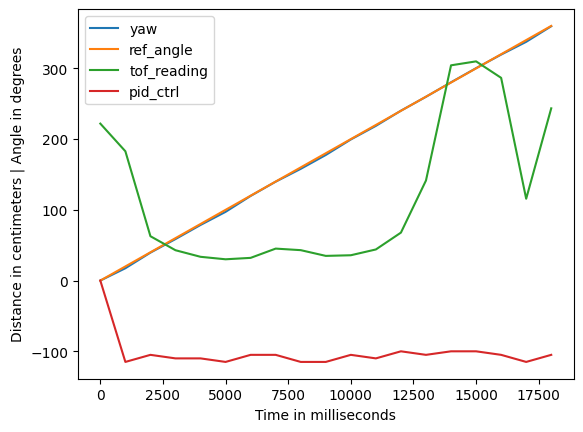

In [188]:
data_N_ = len(timestamp_)

# Time domain figure
time_ = np.linspace(0., (timestamp_[-1] - timestamp_[0]), num=data_N_)
plt.plot(time_, yaw_, label='yaw')
plt.plot(time_, ref_angle_, label='ref_angle')
plt.plot(time_, tof_reading_, label='tof_reading')
plt.plot(time_, pid_ctrl_, label='pid_ctrl')
plt.legend()
plt.title('')
# plt.xlim(0, 2000)
# plt.ylim(-300, 2000)
plt.xlabel('Time in milliseconds')
plt.ylabel('Distance in centimeters | Angle in degrees')
plt.show()

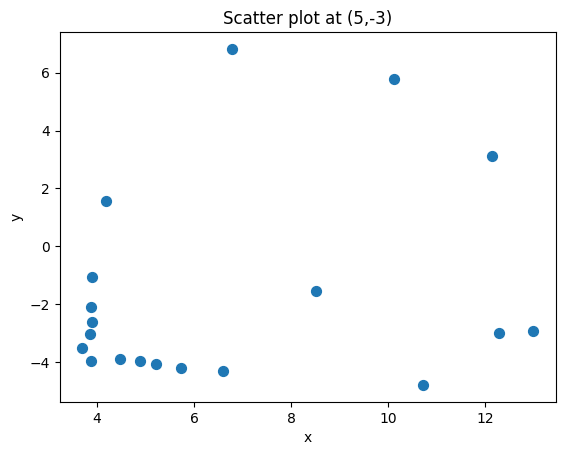

2024-04-17 17:17:03,423 | INFO     |: Disconnected from C0:89:C5:6D:2F:4B


In [196]:
yaw_radian = []
for yaw_i in yaw:
    yaw_radian.append(math.radians(-yaw_i))

# Rotate
x1 = [r/30.48 * np.cos(theta) for r, theta in zip(tof_reading, yaw_radian)]
y1 = [r/30.48 * np.sin(theta) for r, theta in zip(tof_reading, yaw_radian)]

# Shift
x1 = [i + 5 for i in x1]
y1 = [j - 3 for j in y1]

# indices = [i for i, val in enumerate(yaw) if val % 20 == 0]
# yaw_filtered = []
# x1_filtered = []
# y1_filtered = []
# for i in range(0, int(max(yaw))+1, 20):
#     idx = min(range(len(yaw)), key=lambda j: abs(yaw[j] - i))
#     yaw_filtered.append(yaw[idx])
#     x1_filtered.append(x1[idx])
#     y1_filtered.append(y1[idx])

plt.figure()
plt.scatter(x1, y1, s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot at (5,-3)')
plt.show()